# Chapter 15

In [31]:
"""
Google Colaboratoryの場合のみ実行
"""
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
colab_path = "/content/drive/MyDrive/100programming/pythonML/"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import scipy.signal
from tensorflow import keras

plt.style.use({'figure.facecolor': 'white'})

## 15.1

In [2]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(x_padded[i:i + w_rot.shape[0]] * w_rot))
    return np.array(res)

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print("Conv1d Implementation:", conv1d(x, w, p=2, s=1))
print("Numpy results:", np.convolve(x, w, mode="same"))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy results: [ 5 14 16 26 24 34 19 22]


In [3]:
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2 * p[0]
    n2 = X_orig.shape[1] + 2 * p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]: p[0] + X_orig.shape[0], p[1]: p[1]+X_orig.shape[1]] = X_orig
    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0]) / s[0]) + 1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1]) / s[1]) + 1, s[1]):
            X_sub = X_padded[i: i + W_rot.shape[0], j: j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return np.array(res)

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print("Conv2d Implementation:\n", conv2d(X, W, p=(1, 1), s=(1, 1)))
print("Numpy results:\n", scipy.signal.convolve2d(X, W, mode="same"))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
Numpy results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## 15.2

In [4]:
"""
filters: 出力マップの個数
"""
conv_layer = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), kernel_regularizer=keras.regularizers.l2(0.001))
fc_layer = keras.layers.Dense(units=16, kernel_regularizer=keras.regularizers.l2(0.001))

In [11]:
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)
tf.print(f"BCE (w Probas): {bce_probas(y_true=[1], y_pred=probas): .4f} (w Logits): {bce_logits(y_true=[1], y_pred=logits): .4f} ")  # 損失関数の大きさ？

cce_probas = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)
tf.print(f"CCE (w Probas): {cce_probas(y_true=[[0, 0, 1]], y_pred=probas): .4f} (w Logits): {cce_logits(y_true=[[0, 0, 1]], y_pred=logits): .4f} ")

sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
tf.print(f"Sparse CCE (w Probas): {sp_cce_probas(y_true=[2], y_pred=probas): .4f} (w Logits): {sp_cce_logits(y_true=[2], y_pred=logits): .4f} ")

BCE (w Probas):  0.3711 (w Logits):  0.3711 
CCE (w Probas):  0.5996 (w Logits):  0.5996 
Sparse CCE (w Probas):  0.5996 (w Logits):  0.5996 


## 15.3

In [13]:
datasets = tfds.load("mnist", shuffle_files=False)
mnist_train_orig = datasets["train"]
mnist_test_orig = datasets["test"]

In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20
mnist_train = mnist_train_orig.map(lambda item: (tf.cast(item["image"], tf.float32) / 255.0, tf.cast(item["label"], tf.int32)))
mnist_test = mnist_test_orig.map(lambda item: (tf.cast(item["image"], tf.float32) / 255.0, tf.cast(item["label"], tf.int32)))
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding="same", data_format="channels_last", name="conv_1", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_1"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="same", data_format="channels_last", name="conv_2", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_2"))

print(model.compute_output_shape(input_shape=(16, 28, 28, 1)))

model.add(tf.keras.layers.Flatten())
print(model.compute_output_shape(input_shape=(16, 28, 28, 1)))

model.add(tf.keras.layers.Dense(units=1024, name="fc_1", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, name="fc_2", activation="softmax"))

tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

(16, 7, 7, 64)
(16, 3136)


In [25]:
history = model.fit(mnist_train, epochs=NUM_EPOCHS, validation_data=mnist_valid, shuffle=True)  # 50分くらいかかる

Epoch 1/20
782/782 [==============================] - 146s 184ms/step - loss: 0.1373 - accuracy: 0.9573 - val_loss: 0.0460 - val_accuracy: 0.9860
Epoch 2/20
782/782 [==============================] - 140s 178ms/step - loss: 0.0450 - accuracy: 0.9860 - val_loss: 0.0395 - val_accuracy: 0.9882
Epoch 3/20
782/782 [==============================] - 140s 178ms/step - loss: 0.0293 - accuracy: 0.9909 - val_loss: 0.0381 - val_accuracy: 0.9883
Epoch 4/20
782/782 [==============================] - 140s 178ms/step - loss: 0.0228 - accuracy: 0.9930 - val_loss: 0.0387 - val_accuracy: 0.9889
Epoch 5/20
782/782 [==============================] - 139s 177ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.0381 - val_accuracy: 0.9900
Epoch 6/20
782/782 [==============================] - 139s 177ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0380 - val_accuracy: 0.9900
Epoch 7/20
782/782 [==============================] - 139s 177ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0443 -

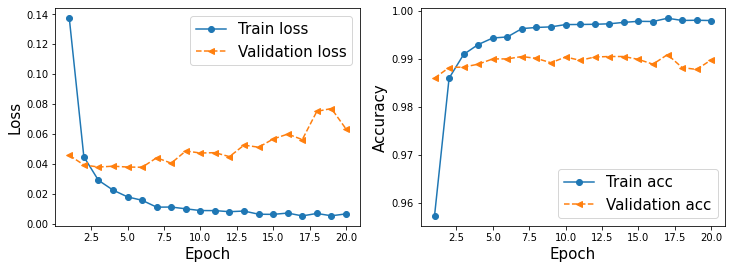

In [26]:
hist = history.history
x_arr = np.arange(len(hist["loss"])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist["loss"], "-o", label="Train loss")
ax.plot(x_arr, hist["val_loss"], "--<", label="Validation loss")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist["accuracy"], "-o", label="Train acc")
ax.plot(x_arr, hist["val_accuracy"], "--<", label="Validation acc")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
ax.legend(fontsize=15)
plt.show()

500/500 [==============================] - 8s 15ms/step - loss: 0.0409 - accuracy: 0.9923
Test Acc.: 99.23
TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


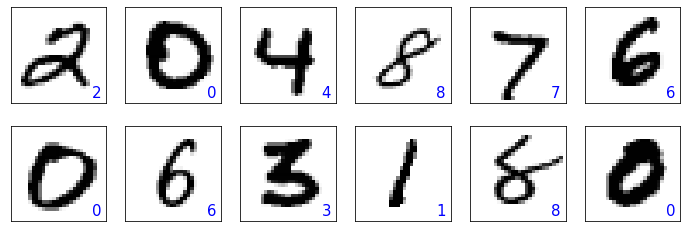

In [29]:
test_results = model.evaluate(mnist_test.batch(20))
print(f"Test Acc.: {test_results[1]*100:.2f}")

batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
tf.print(preds.shape)

preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap="gray_r")
    ax.text(0.9, 0.1, f"{preds[i]}", size=15, color="blue", horizontalalignment="center", verticalalignment="center", transform=ax.transAxes)
plt.show()

## 15.4

In [30]:
celeba = tfds.load("celeb_a", shuffle_files=False)  # できない
celeba_train = celeba["train"]
celeba_valid = celeba["validation"]
celeba_test = celeba["test"]

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print(f"Train set: {count_items(celeba_train)}")
print(f"Validation set: {count_items(celeba_valid)}")
print(f"Test set: {count_items(celeba_trest)}")

celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)
print(f"Train set: {count_items(celeba_train)}")
print(f"Validation set: {count_items(celeba_valid)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

NonMatchingChecksumError: ignored

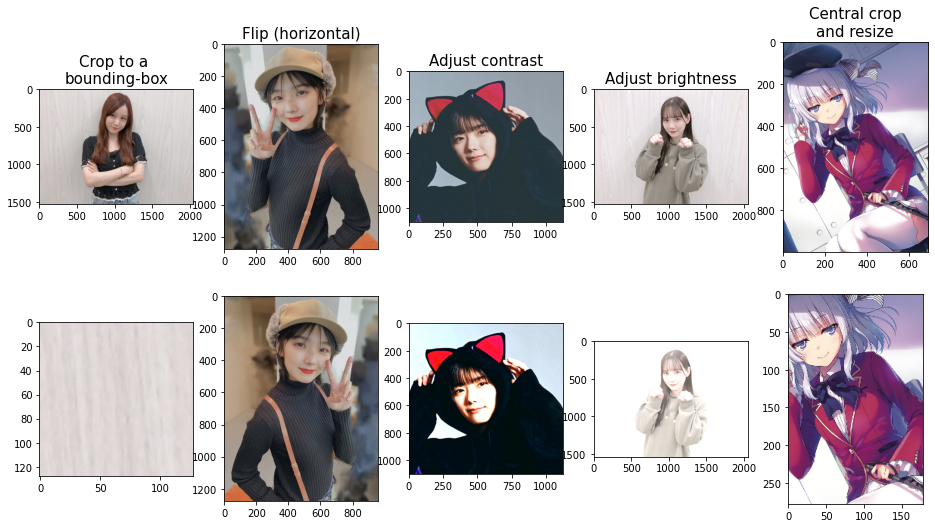

In [44]:
examples = []
"""for example in celeba_train.take(5):
    exapmles.append(example["image"])"""

from PIL import Image
for i in range(5):
    file_name = colab_path + "images/image" + str(i+1) + ".jpg"
    image = Image.open(file_name)
    examples.append(np.array(image))

fig = plt.figure(figsize=(16, 8.5))
ax = fig.add_subplot(2, 5, 1)
ax.set_title("Crop to a \nbounding-box", size=15)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
img_cropped = tf.image.crop_to_bounding_box(examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

ax = fig.add_subplot(2, 5, 2)
ax.set_title("Flip (horizontal)", size=15)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

ax = fig.add_subplot(2, 5, 3)
ax.set_title("Adjust contrast", size=15)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = tf.image.adjust_contrast(examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

ax = fig.add_subplot(2, 5, 4)
ax.set_title("Adjust brightness", size=15)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = tf.image.adjust_brightness(examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

ax = fig.add_subplot(2, 5, 5)
ax.set_title("Central crop\nand resize", size=15)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
img_center_crop = tf.image.central_crop(examples[4], 0.7)
img_resized = tf.image.resize(img_center_crop, size=(278, 178))
ax.imshow(img_resized.numpy().astype("uint8"))

plt.show()

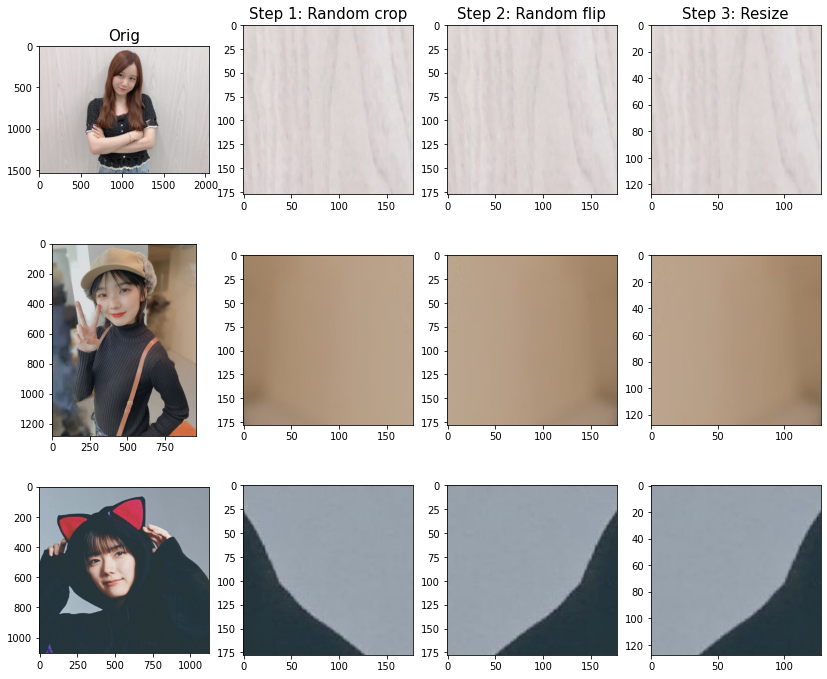

In [47]:
tf.random.set_seed(1)
fig = plt.figure(figsize=(14, 12))
for i, example in enumerate(examples[0:3]):  # celeb_aを使うときは要変更
    #image = examples["image"]
    image = example  # celeb_aを使うときはこの行を消して上の行を実行
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title("Orig", size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title("Step 1: Random crop", size=15)

    ax = fig.add_subplot(3, 4, 4*i+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title("Step 2: Random flip", size=15)

    ax = fig.add_subplot(3, 4, 4*i+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title("Step 3: Resize", size=15)

plt.show()

In [48]:
def preprocess(example, size=(64, 64), mode="train"):
    image = example["image"]
    label = example["attribute"]["Male"]
    if mode == "train":
        image_cropped = tf.image.random_crop(image, size=(178, 178, 3))
        image_resized = tf.image.resize(image_cropped, size=size)
        return (image_flip / 255.0, tf.cast(label, tf.int32))
    else:
        image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0, target_height=178, target_width=178)
        image_resized = tf.image.resize(image_cropped, size=size)
        return (image_resized / 255.0, tf.cast(label ,tf.int32))

In [ ]:
tf.random.set_seed(1)
ds = celaba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)
ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode="train"))
fig = plt.figure(figsize=(15, 6))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(exapmles[0])
plt.show()

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
step_per_epochs = np.ceil(16000 / BATCH_SIZE)
ds_train = celeba_train.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode="train"))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)
ds_valid = celeba_valid.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode="eval"))
ds_valid = ds_valid.batch(BATCH_SIZE)

In [52]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D((2, 2)),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D((2, 2)),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
                             tf.keras.layers.MaxPooling2D((2, 2)),
                             tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")
])

print(model.compute_output_shape(input_shape=(None, 64, 64, 3)))

model.add(tf.keras.layers.GlobalAveragePooling2D())
print(model.compute_output_shape(input_shape=(None, 64, 64, 3)))

model.add(tf.keras.layers.Dense(1, activation=None))
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

(None, 8, 8, 256)
(None, 256)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)     

In [ ]:
history = model.fit(ds_train, validation_data=ds_valid, epochs=20, steps_per_epoch=steps_per_epoch)

In [ ]:
hist = history.history
x_arr = np.arange(len(hist["loss"])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist["loss"], "-o", label="Train loss")
ax.plot(x_arr, hist["val_loss"], "--<", label="Validation loss")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist["accuracy"], "-o", label="Train acc")
ax.plot(x_arr, hist["val_accuracy"], "--<", label="Validation acc")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
ax.legend(fontsize=15)
plt.show()

In [ ]:
history = model.fit(ds_train, validation_data=ds_valid, epochs=30, initial_epoch=20, steps_per_epoch=steps_per_epoch)

In [ ]:
ds_test = celeba_test.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode="eval")).batch(32)
test_results = model.evaluate(ds_test, verbose=0)
print(f"Test Acc: {test_results[1]*100:.2f}")

In [ ]:
ds = ds_test.unbatch().take(10)
pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100
fig = plt.figure(figsize=(15, 7))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label = "Male"
    else:
        label = "Female"
    ax.text(0.5, -0.15, f"GT: {label:s}\nPr(Male)={probas[j]:.0f}%", size=16, horizontalalignment="center", verticalalignment="center", transform=ax.transAxes)
plt.show()